# 1. Import Library

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
import os
import shutil
import tensorflow as tf
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import losses
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.python.keras.utils import np_utils
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc
from ResNet import ResnetBuilder # ResNet.py
import json
import itertools
import gc
import glob
from IPython.display import clear_output

# 2. Data Processing

## 2.1 Load Data

In [2]:
# 元データはCSV．各列がピクセルの位置を示しており各行が個々のデータを表す．
train = pd.read_csv("./data/train.csv") # trainのみ1列目にラベル(0-9)が与えられている
test = pd.read_csv("./data/test.csv")

# 画像サイズ
img_size_x = 28
img_size_y = 28
channels = 1

# trainラベル
label_num = np.array(train.label) # 0-9
label = pd.get_dummies(label_num).values # one-hot encoding
class_names = np.unique(label_num).astype("str") # クラス名 "0"-"9"
n_classes = len(np.unique(label_num)) # クラス数　=　10

# trainからラベル列を削除
train = train.drop(labels = ["label"], axis = 1) 

## 2.2 Preprocess

In [3]:
# 平均０，分散１となるように各データを正規化
train = scale(train, axis=1)
test = scale(test, axis=1)

# 元データを入力形状(データ数*28*28*1)に変換
train = train.reshape(-1,28,28,1).astype('float32')
test = test.reshape(-1,28,28,1).astype('float32')

C:\Users\naohiro\Anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  
C:\Users\naohiro\Anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  This is separate from the ipykernel package so we can avoid doing imports until


## 2.3 Show Image Sample

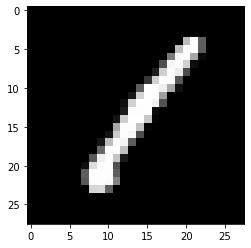

In [4]:
plt.figure()
plt.imshow(train[0,:,:,0], cmap='gray')
plt.show()

# 3. Model Summary

## 3.1 Structure

In [6]:
inputShape=(img_size_x, img_size_y, channels)
ResNetModel = ResnetBuilder.build_resnet_50(inputShape, n_classes) # ResNet-50モデル
ResNetModel.summary()
clear_session()
del ResNetModel
gc.collect()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   3200        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 14, 14, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 14, 14, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

102835

## 3.2 Result Setting

In [4]:
# modelのバージョン毎に結果保存用のフォルダを作成
model_name = "ResNet50_epoch10_ensemble" # 設定に変更があった場合ここだけ変更
csv_dir = "./Result/"+model_name 
conf_dir = csv_dir+"/CM_result" # 混合行列画像保存用のサブフォルダ
model_dir = csv_dir+"/model_dir"

# 新規にフォルダを作成する関数．同名のフォルダがすでに存在する場合は削除して作り直す
def my_makedirs(path):
    if not os.path.isdir(path):
        os.makedirs(path)
    else:
        shutil.rmtree(path)
        os.makedirs(path)
        
# 結果保存用フォルダの作成
my_makedirs(csv_dir)
my_makedirs(conf_dir)
my_makedirs(model_dir)

# 4. Evaluate Model

## 4.1 Training Setting

In [5]:
# 学習の設定
inputShape=(img_size_x, img_size_y, channels)
batch_size = 512 # 32, 64, 128, 256, 512(first), 1024, 2048など調整
n_epoch = 10 # エポック数
learning_rate = 0.001 #0.003
early_stopping_patience = 300 # 性能向上がない場合，学習を早期終了するエポック数
sp = 10 # 交差検証の分割数

# 評価指標の設定(accuracy, 各クラスのprecision, recall, fscoreとそれらの平均)
predict = np.empty([len(label), n_classes])
predict_label = np.empty([len(label), n_classes])
acc_list = np.empty([sp,1])
precision_list = np.empty([sp, n_classes])
recall_list = np.empty([sp, n_classes])
fscore_list = np.empty([sp, n_classes])
avg_precision = np.empty([sp,1])
avg_recall = np.empty([sp,1])
avg_fscore = np.empty([sp,1])

## 4.2 Training and Validation (10-fold cross validation)

### 4.2.1 Each fold iteration

Iteration No. 1

Train on 37794 samples, validate on 4206 samples
Epoch 1/10
37376/37794 [============================>.] - ETA: 0s - loss: 4.9041 - acc: 0.9418
Epoch 00001: val_loss improved from inf to 11.94276, saving model to img_classifier_model_1_ResNet50_epoch10_ensemble.h5
37794/37794 [==============================] - 29s 771us/sample - loss: 4.8974 - acc: 0.9421 - val_loss: 11.9428 - val_acc: 0.3519
Epoch 2/10
37376/37794 [============================>.] - ETA: 0s - loss: 3.8665 - acc: 0.9923
Epoch 00002: val_loss improved from 11.94276 to 3.64119, saving model to img_classifier_model_1_ResNet50_epoch10_ensemble.h5
37794/37794 [==============================] - 14s 364us/sample - loss: 3.8630 - acc: 0.9923 - val_loss: 3.6412 - val_acc: 0.9634
Epoch 3/10
37376/37794 [============================>.] - ETA: 0s - loss: 3.2768 - acc: 0.9983
Epoch 00003: val_loss improved from 3.64119 to 3.10771, saving model to img_classifier_model_1_ResNet50_epoch10_ensemble.h5
37794/37794 [=====

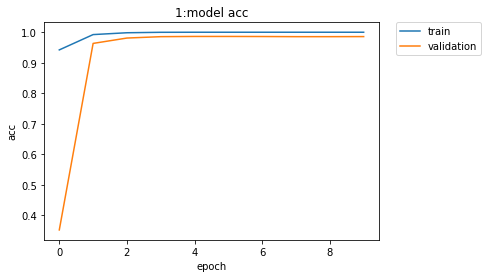

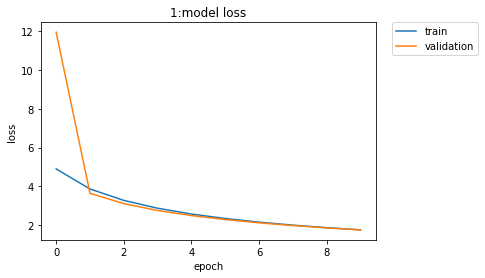

Done compiling best model.


1. Accuracy on validation data: 0.985735
Classification Report
              precision    recall  f1-score   support

           0    0.98798   0.99275   0.99036       414
           1    0.99574   0.99787   0.99681       469
           2    0.97867   0.98804   0.98333       418
           3    0.99767   0.98165   0.98960       436
           4    0.97826   0.99265   0.98540       408
           5    0.98684   0.98684   0.98684       380
           6    0.98798   0.99275   0.99036       414
           7    0.98845   0.97052   0.97941       441
           8    0.97567   0.98526   0.98044       407
           9    0.97831   0.96897   0.97362       419

   micro avg    0.98573   0.98573   0.98573      4206
   macro avg    0.98556   0.98573   0.98562      4206
weighted avg    0.98578   0.98573   0.98573      4206
 samples avg    0.98573   0.98573   0.98573      4206





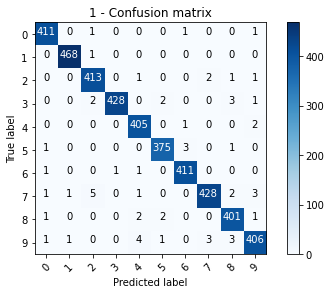

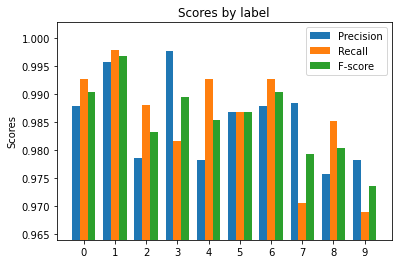

Iteration No. 2

Train on 37796 samples, validate on 4204 samples
Epoch 1/10
37376/37796 [============================>.] - ETA: 0s - loss: 4.8974 - acc: 0.9422
Epoch 00001: val_loss improved from inf to 8.94234, saving model to img_classifier_model_2_ResNet50_epoch10_ensemble.h5
37796/37796 [==============================] - 25s 665us/sample - loss: 4.8906 - acc: 0.9425 - val_loss: 8.9423 - val_acc: 0.4843
Epoch 2/10
37376/37796 [============================>.] - ETA: 0s - loss: 3.8617 - acc: 0.9912
Epoch 00002: val_loss improved from 8.94234 to 3.62193, saving model to img_classifier_model_2_ResNet50_epoch10_ensemble.h5
37796/37796 [==============================] - 14s 359us/sample - loss: 3.8580 - acc: 0.9913 - val_loss: 3.6219 - val_acc: 0.9629
Epoch 3/10
37376/37796 [============================>.] - ETA: 0s - loss: 3.2709 - acc: 0.9983
Epoch 00003: val_loss improved from 3.62193 to 3.10012, saving model to img_classifier_model_2_ResNet50_epoch10_ensemble.h5
37796/37796 [========

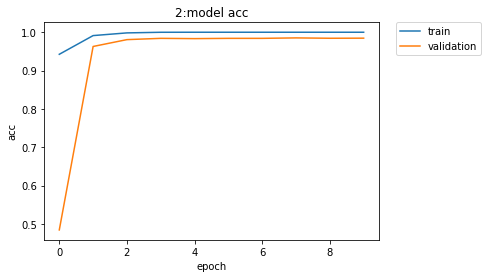

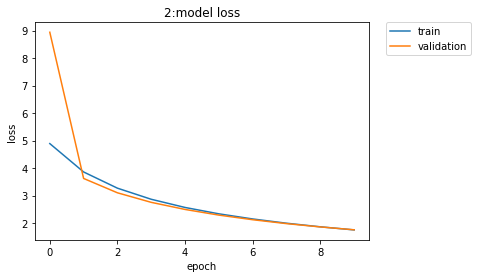

Done compiling best model.


2. Accuracy on validation data: 0.984539
Classification Report
              precision    recall  f1-score   support

           0    0.99274   0.99034   0.99154       414
           1    1.00000   0.98507   0.99248       469
           2    0.98568   0.98804   0.98686       418
           3    0.98845   0.98391   0.98618       435
           4    0.99246   0.96814   0.98015       408
           5    0.97638   0.97895   0.97766       380
           6    0.98789   0.98551   0.98670       414
           7    0.99087   0.98636   0.98861       440
           8    0.97816   0.99017   0.98413       407
           9    0.95172   0.98807   0.96956       419

   micro avg    0.98454   0.98454   0.98454      4204
   macro avg    0.98443   0.98446   0.98439      4204
weighted avg    0.98472   0.98454   0.98457      4204
 samples avg    0.98454   0.98454   0.98454      4204





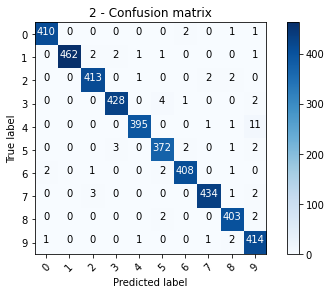

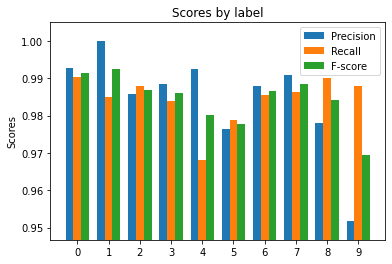

Iteration No. 3

Train on 37798 samples, validate on 4202 samples
Epoch 1/10
37376/37798 [============================>.] - ETA: 0s - loss: 4.8891 - acc: 0.9429  ETA: 16s - loss: 5.31 - 
Epoch 00001: val_loss improved from inf to 9.25099, saving model to img_classifier_model_3_ResNet50_epoch10_ensemble.h5
37798/37798 [==============================] - 25s 668us/sample - loss: 4.8817 - acc: 0.9434 - val_loss: 9.2510 - val_acc: 0.5457
Epoch 2/10
37376/37798 [============================>.] - ETA: 0s - loss: 3.8454 - acc: 0.9913
Epoch 00002: val_loss improved from 9.25099 to 3.61159, saving model to img_classifier_model_3_ResNet50_epoch10_ensemble.h5
37798/37798 [==============================] - 14s 369us/sample - loss: 3.8420 - acc: 0.9912 - val_loss: 3.6116 - val_acc: 0.9626
Epoch 3/10
37376/37798 [============================>.] - ETA: 0s - loss: 3.2515 - acc: 0.9982
Epoch 00003: val_loss improved from 3.61159 to 3.06307, saving model to img_classifier_model_3_ResNet50_epoch10_ensembl

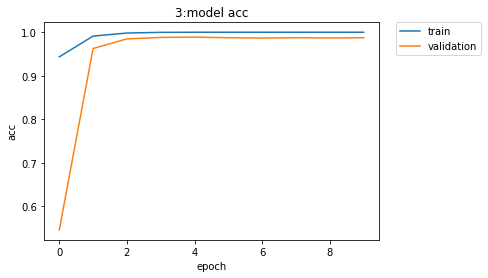

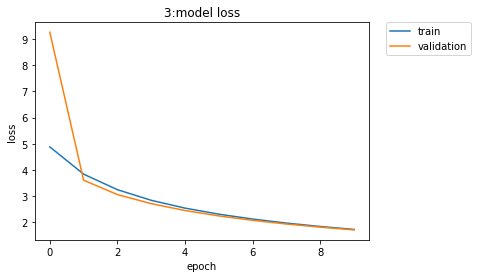

Done compiling best model.


3. Accuracy on validation data: 0.987387
Classification Report
              precision    recall  f1-score   support

           0    0.98091   0.99516   0.98798       413
           1    0.99358   0.98934   0.99145       469
           2    0.98077   0.97608   0.97842       418
           3    0.97936   0.98161   0.98048       435
           4    0.99017   0.99017   0.99017       407
           5    0.99468   0.98421   0.98942       380
           6    0.99043   1.00000   0.99519       414
           7    0.99091   0.99091   0.99091       440
           8    0.99007   0.98034   0.98519       407
           9    0.98333   0.98568   0.98451       419

   micro avg    0.98739   0.98739   0.98739      4202
   macro avg    0.98742   0.98735   0.98737      4202
weighted avg    0.98741   0.98739   0.98738      4202
 samples avg    0.98739   0.98739   0.98739      4202





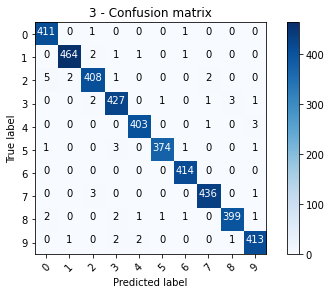

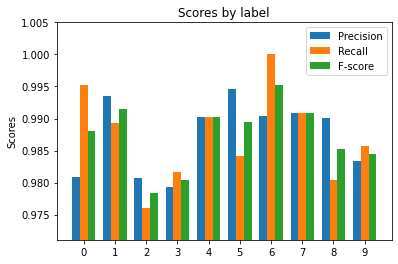

Iteration No. 4

Train on 37799 samples, validate on 4201 samples
Epoch 1/10
37376/37799 [============================>.] - ETA: 0s - loss: 4.8633 - acc: 0.9453
Epoch 00001: val_loss improved from inf to 6.35908, saving model to img_classifier_model_4_ResNet50_epoch10_ensemble.h5
37799/37799 [==============================] - 25s 654us/sample - loss: 4.8558 - acc: 0.9458 - val_loss: 6.3591 - val_acc: 0.6632
Epoch 2/10
37376/37799 [============================>.] - ETA: 0s - loss: 3.7993 - acc: 0.9913
Epoch 00002: val_loss improved from 6.35908 to 3.53927, saving model to img_classifier_model_4_ResNet50_epoch10_ensemble.h5
37799/37799 [==============================] - 14s 366us/sample - loss: 3.7956 - acc: 0.9913 - val_loss: 3.5393 - val_acc: 0.9683
Epoch 3/10
37376/37799 [============================>.] - ETA: 0s - loss: 3.1989 - acc: 0.9981
Epoch 00003: val_loss improved from 3.53927 to 3.02179, saving model to img_classifier_model_4_ResNet50_epoch10_ensemble.h5
37799/37799 [========

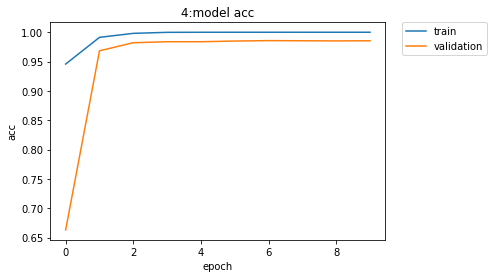

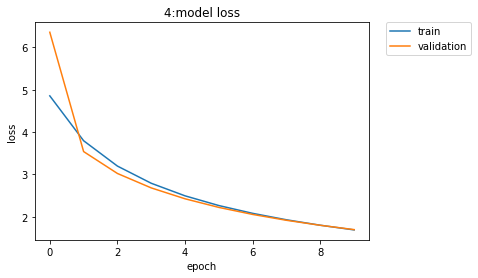

Done compiling best model.


4. Accuracy on validation data: 0.985480
Classification Report
              precision    recall  f1-score   support

           0    0.98561   0.99516   0.99036       413
           1    0.98523   0.99574   0.99046       469
           2    0.98812   0.99522   0.99166       418
           3    0.99074   0.98391   0.98731       435
           4    0.99750   0.98034   0.98885       407
           5    0.98413   0.97895   0.98153       380
           6    0.98795   0.99034   0.98914       414
           7    0.97763   0.99318   0.98534       440
           8    0.98010   0.97044   0.97525       406
           9    0.97831   0.96897   0.97362       419

   micro avg    0.98548   0.98548   0.98548      4201
   macro avg    0.98553   0.98522   0.98535      4201
weighted avg    0.98550   0.98548   0.98546      4201
 samples avg    0.98548   0.98548   0.98548      4201





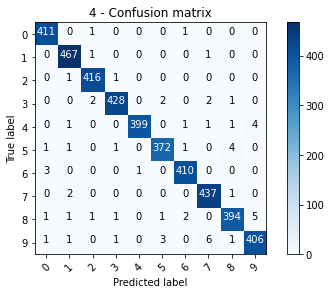

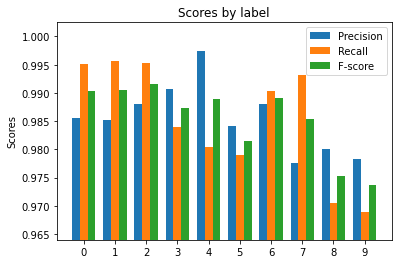

Iteration No. 5

Train on 37800 samples, validate on 4200 samples
Epoch 1/10
37376/37800 [============================>.] - ETA: 0s - loss: 4.8836 - acc: 0.9453
Epoch 00001: val_loss improved from inf to 8.80920, saving model to img_classifier_model_5_ResNet50_epoch10_ensemble.h5
37800/37800 [==============================] - 25s 657us/sample - loss: 4.8760 - acc: 0.9458 - val_loss: 8.8092 - val_acc: 0.5590
Epoch 2/10
37376/37800 [============================>.] - ETA: 0s - loss: 3.8363 - acc: 0.9925- ETA: 3s - loss: 3.9
Epoch 00002: val_loss improved from 8.80920 to 3.58804, saving model to img_classifier_model_5_ResNet50_epoch10_ensemble.h5
37800/37800 [==============================] - 14s 365us/sample - loss: 3.8328 - acc: 0.9924 - val_loss: 3.5880 - val_acc: 0.9693
Epoch 3/10
37376/37800 [============================>.] - ETA: 0s - loss: 3.2446 - acc: 0.9979
Epoch 00003: val_loss improved from 3.58804 to 3.07292, saving model to img_classifier_model_5_ResNet50_epoch10_ensemble.h5


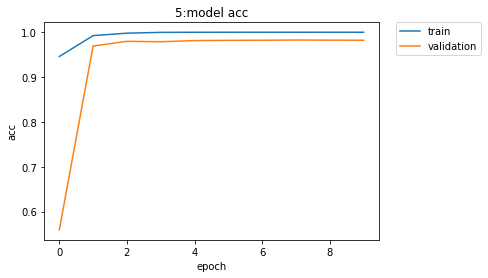

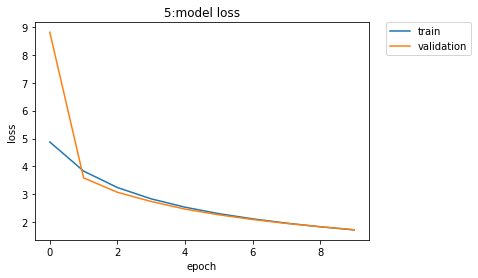

Done compiling best model.


5. Accuracy on validation data: 0.982143
Classification Report
              precision    recall  f1-score   support

           0    0.98100   1.00000   0.99041       413
           1    0.98927   0.98504   0.98715       468
           2    0.98544   0.97129   0.97831       418
           3    0.99065   0.97471   0.98262       435
           4    0.99250   0.97543   0.98389       407
           5    0.98663   0.97105   0.97878       380
           6    0.99031   0.98792   0.98912       414
           7    0.96882   0.98864   0.97863       440
           8    0.96635   0.99015   0.97810       406
           9    0.97150   0.97613   0.97381       419

   micro avg    0.98214   0.98214   0.98214      4200
   macro avg    0.98225   0.98204   0.98208      4200
weighted avg    0.98226   0.98214   0.98214      4200
 samples avg    0.98214   0.98214   0.98214      4200





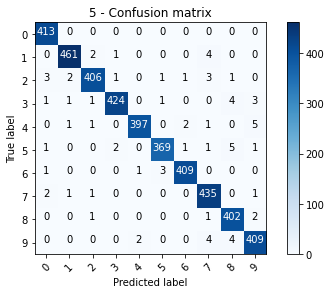

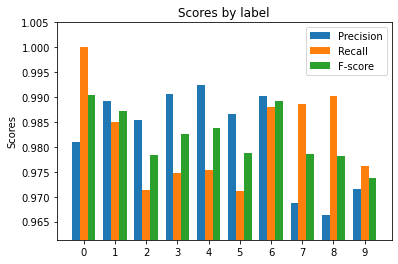

Iteration No. 6

Train on 37801 samples, validate on 4199 samples
Epoch 1/10
37376/37801 [============================>.] - ETA: 0s - loss: 4.9039 - acc: 0.9422
Epoch 00001: val_loss improved from inf to 10.14596, saving model to img_classifier_model_6_ResNet50_epoch10_ensemble.h5
37801/37801 [==============================] - 25s 666us/sample - loss: 4.8967 - acc: 0.9426 - val_loss: 10.1460 - val_acc: 0.3506
Epoch 2/10
37376/37801 [============================>.] - ETA: 0s - loss: 3.8659 - acc: 0.9925
Epoch 00002: val_loss improved from 10.14596 to 3.69387, saving model to img_classifier_model_6_ResNet50_epoch10_ensemble.h5
37801/37801 [==============================] - 14s 365us/sample - loss: 3.8622 - acc: 0.9925 - val_loss: 3.6939 - val_acc: 0.9526
Epoch 3/10
37376/37801 [============================>.] - ETA: 0s - loss: 3.2777 - acc: 0.9989- ETA: 4s -
Epoch 00003: val_loss improved from 3.69387 to 3.11941, saving model to img_classifier_model_6_ResNet50_epoch10_ensemble.h5
37801/3

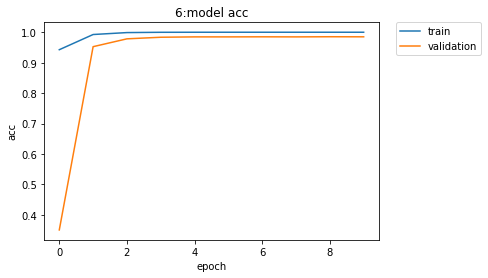

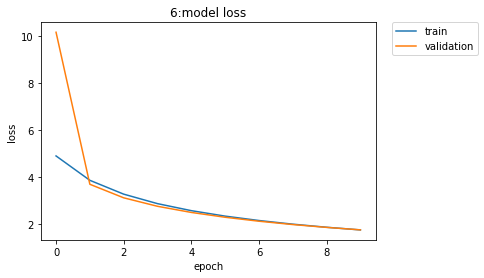

Done compiling best model.


6. Accuracy on validation data: 0.984996
Classification Report
              precision    recall  f1-score   support

           0    0.98795   0.99274   0.99034       413
           1    0.99359   0.99359   0.99359       468
           2    0.98333   0.98804   0.98568       418
           3    0.99301   0.97931   0.98611       435
           4    0.99007   0.98034   0.98519       407
           5    0.98936   0.98153   0.98543       379
           6    0.99272   0.98792   0.99031       414
           7    0.95852   0.99773   0.97773       440
           8    0.97324   0.98522   0.97919       406
           9    0.99017   0.96181   0.97579       419

   micro avg    0.98500   0.98500   0.98500      4199
   macro avg    0.98520   0.98482   0.98494      4199
weighted avg    0.98516   0.98500   0.98500      4199
 samples avg    0.98500   0.98500   0.98500      4199





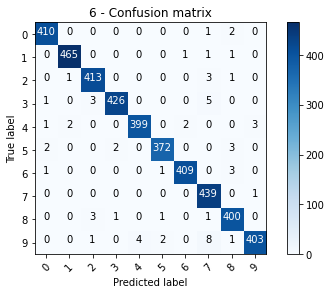

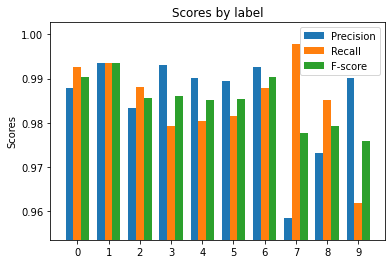

Iteration No. 7

Train on 37801 samples, validate on 4199 samples
Epoch 1/10
37376/37801 [============================>.] - ETA: 0s - loss: 4.8925 - acc: 0.9420
Epoch 00001: val_loss improved from inf to 7.24153, saving model to img_classifier_model_7_ResNet50_epoch10_ensemble.h5
37801/37801 [==============================] - 23s 599us/sample - loss: 4.8858 - acc: 0.9424 - val_loss: 7.2415 - val_acc: 0.5894
Epoch 2/10
37376/37801 [============================>.] - ETA: 0s - loss: 3.8441 - acc: 0.9924
Epoch 00002: val_loss improved from 7.24153 to 3.59533, saving model to img_classifier_model_7_ResNet50_epoch10_ensemble.h5
37801/37801 [==============================] - 14s 365us/sample - loss: 3.8404 - acc: 0.9924 - val_loss: 3.5953 - val_acc: 0.9695
Epoch 3/10
37376/37801 [============================>.] - ETA: 0s - loss: 3.2523 - acc: 0.9984
Epoch 00003: val_loss improved from 3.59533 to 3.07353, saving model to img_classifier_model_7_ResNet50_epoch10_ensemble.h5
37801/37801 [========

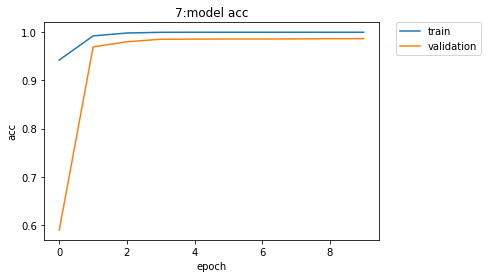

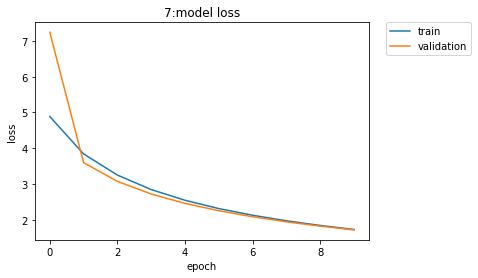

Done compiling best model.


7. Accuracy on validation data: 0.986663
Classification Report
              precision    recall  f1-score   support

           0    0.97387   0.99274   0.98321       413
           1    1.00000   0.99786   0.99893       468
           2    0.99034   0.98086   0.98558       418
           3    0.99533   0.97931   0.98725       435
           4    0.99502   0.98280   0.98888       407
           5    0.99202   0.98417   0.98808       379
           6    0.99022   0.97826   0.98420       414
           7    0.98871   0.99545   0.99207       440
           8    0.96651   0.99507   0.98058       406
           9    0.97387   0.97852   0.97619       419

   micro avg    0.98666   0.98666   0.98666      4199
   macro avg    0.98659   0.98651   0.98650      4199
weighted avg    0.98679   0.98666   0.98668      4199
 samples avg    0.98666   0.98666   0.98666      4199





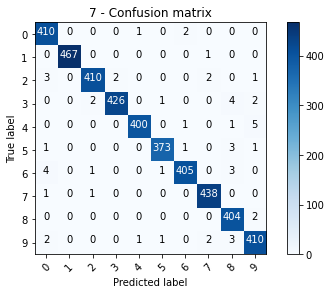

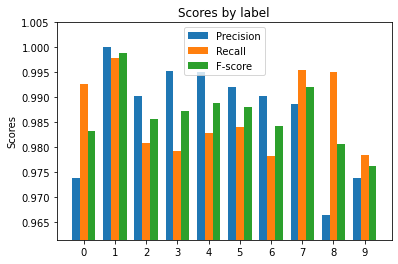

Iteration No. 8

Train on 37803 samples, validate on 4197 samples
Epoch 1/10
37376/37803 [============================>.] - ETA: 0s - loss: 4.8745 - acc: 0.9434
Epoch 00001: val_loss improved from inf to 6.58831, saving model to img_classifier_model_8_ResNet50_epoch10_ensemble.h5
37803/37803 [==============================] - 25s 661us/sample - loss: 4.8675 - acc: 0.9438 - val_loss: 6.5883 - val_acc: 0.6312
Epoch 2/10
37376/37803 [============================>.] - ETA: 0s - loss: 3.8186 - acc: 0.9926
Epoch 00002: val_loss improved from 6.58831 to 3.57207, saving model to img_classifier_model_8_ResNet50_epoch10_ensemble.h5
37803/37803 [==============================] - 14s 366us/sample - loss: 3.8148 - acc: 0.9925 - val_loss: 3.5721 - val_acc: 0.9683
Epoch 3/10
37376/37803 [============================>.] - ETA: 0s - loss: 3.2247 - acc: 0.9983
Epoch 00003: val_loss improved from 3.57207 to 3.04059, saving model to img_classifier_model_8_ResNet50_epoch10_ensemble.h5
37803/37803 [========

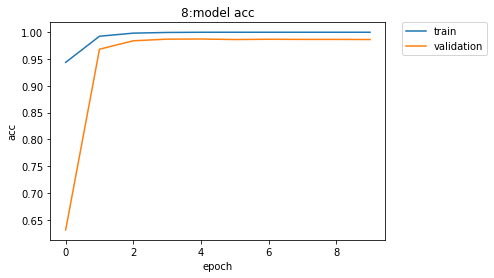

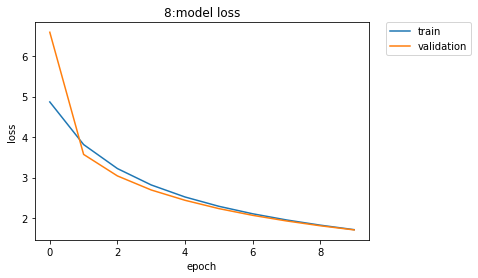

Done compiling best model.


8. Accuracy on validation data: 0.986419
Classification Report
              precision    recall  f1-score   support

           0    0.99517   0.99758   0.99637       413
           1    0.99362   0.99786   0.99574       468
           2    0.99275   0.98561   0.98917       417
           3    0.98845   0.98391   0.98618       435
           4    0.98054   0.99017   0.98533       407
           5    0.99200   0.98153   0.98674       379
           6    0.99512   0.98789   0.99149       413
           7    0.98420   0.99091   0.98754       440
           8    0.95238   0.98522   0.96852       406
           9    0.99017   0.96181   0.97579       419

   micro avg    0.98642   0.98642   0.98642      4197
   macro avg    0.98644   0.98625   0.98629      4197
weighted avg    0.98656   0.98642   0.98643      4197
 samples avg    0.98642   0.98642   0.98642      4197





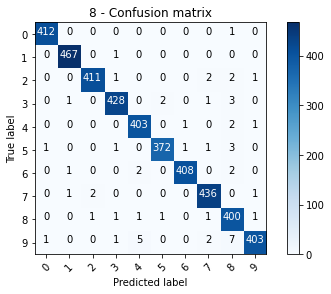

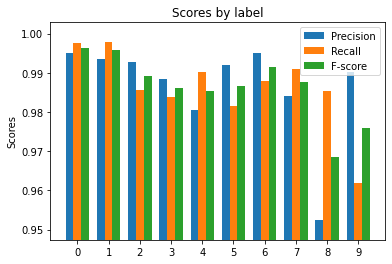

Iteration No. 9

Train on 37804 samples, validate on 4196 samples
Epoch 1/10
37376/37804 [============================>.] - ETA: 0s - loss: 4.8941 - acc: 0.9411
Epoch 00001: val_loss improved from inf to 15.66334, saving model to img_classifier_model_9_ResNet50_epoch10_ensemble.h5
37804/37804 [==============================] - 25s 659us/sample - loss: 4.8872 - acc: 0.9415 - val_loss: 15.6633 - val_acc: 0.1795
Epoch 2/10
37376/37804 [============================>.] - ETA: 0s - loss: 3.8425 - acc: 0.9924
Epoch 00002: val_loss improved from 15.66334 to 3.79894, saving model to img_classifier_model_9_ResNet50_epoch10_ensemble.h5
37804/37804 [==============================] - 14s 367us/sample - loss: 3.8388 - acc: 0.9925 - val_loss: 3.7989 - val_acc: 0.9102
Epoch 3/10
37376/37804 [============================>.] - ETA: 0s - loss: 3.2486 - acc: 0.9982
Epoch 00003: val_loss improved from 3.79894 to 3.07112, saving model to img_classifier_model_9_ResNet50_epoch10_ensemble.h5
37804/37804 [=====

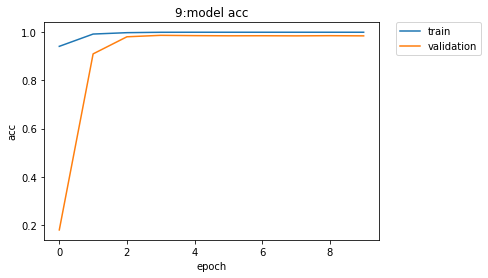

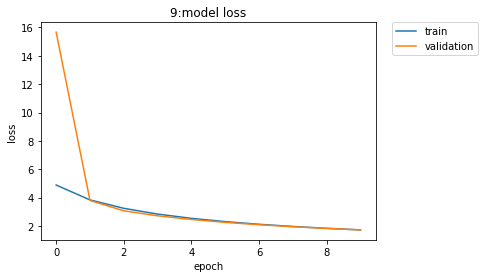

Done compiling best model.


9. Accuracy on validation data: 0.984986
Classification Report
              precision    recall  f1-score   support

           0    0.96941   0.99758   0.98329       413
           1    0.98732   0.99786   0.99256       468
           2    0.99031   0.98082   0.98554       417
           3    0.99764   0.97011   0.98368       435
           4    0.98537   0.99263   0.98898       407
           5    0.98684   0.98945   0.98814       379
           6    0.99515   0.99274   0.99394       413
           7    0.97753   0.98864   0.98305       440
           8    0.97561   0.98522   0.98039       406
           9    0.98519   0.95455   0.96962       418

   micro avg    0.98499   0.98499   0.98499      4196
   macro avg    0.98504   0.98496   0.98492      4196
weighted avg    0.98509   0.98499   0.98496      4196
 samples avg    0.98499   0.98499   0.98499      4196





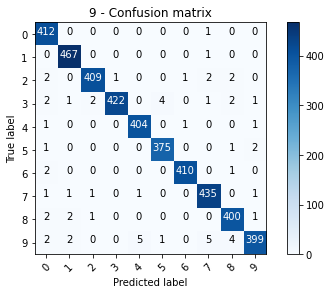

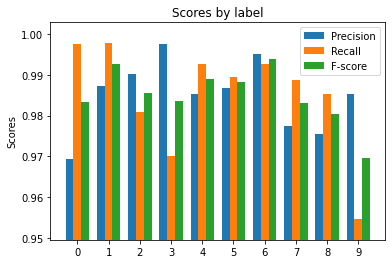

Iteration No. 10

Train on 37804 samples, validate on 4196 samples
Epoch 1/10
37376/37804 [============================>.] - ETA: 0s - loss: 4.8855 - acc: 0.9416
Epoch 00001: val_loss improved from inf to 6.74921, saving model to img_classifier_model_10_ResNet50_epoch10_ensemble.h5
37804/37804 [==============================] - 23s 603us/sample - loss: 4.8785 - acc: 0.9420 - val_loss: 6.7492 - val_acc: 0.7071
Epoch 2/10
37376/37804 [============================>.] - ETA: 0s - loss: 3.8320 - acc: 0.9911
Epoch 00002: val_loss improved from 6.74921 to 3.60553, saving model to img_classifier_model_10_ResNet50_epoch10_ensemble.h5
37804/37804 [==============================] - 14s 365us/sample - loss: 3.8284 - acc: 0.9911 - val_loss: 3.6055 - val_acc: 0.9600
Epoch 3/10
37376/37804 [============================>.] - ETA: 0s - loss: 3.2355 - acc: 0.9982
Epoch 00003: val_loss improved from 3.60553 to 3.06091, saving model to img_classifier_model_10_ResNet50_epoch10_ensemble.h5
37804/37804 [====

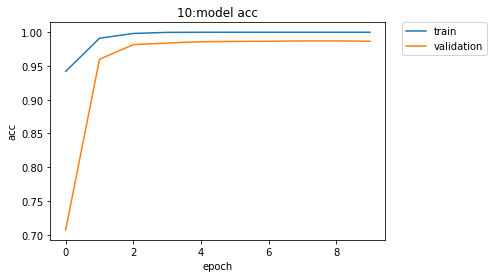

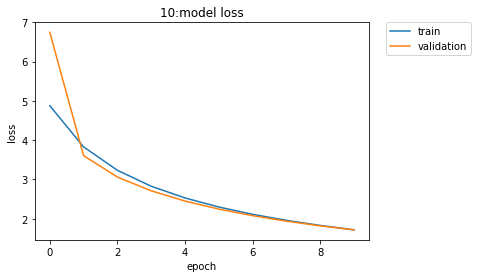

Done compiling best model.


10. Accuracy on validation data: 0.986654
Classification Report
              precision    recall  f1-score   support

           0    0.98321   0.99274   0.98795       413
           1    0.98312   0.99573   0.98938       468
           2    0.98345   0.99760   0.99048       417
           3    0.97936   0.98161   0.98048       435
           4    0.99256   0.98280   0.98765       407
           5    0.98930   0.97625   0.98274       379
           6    0.99038   0.99758   0.99397       413
           7    0.98627   0.97955   0.98290       440
           8    0.99499   0.97783   0.98634       406
           9    0.98561   0.98325   0.98443       418

   micro avg    0.98665   0.98665   0.98665      4196
   macro avg    0.98683   0.98649   0.98663      4196
weighted avg    0.98669   0.98665   0.98664      4196
 samples avg    0.98665   0.98665   0.98665      4196





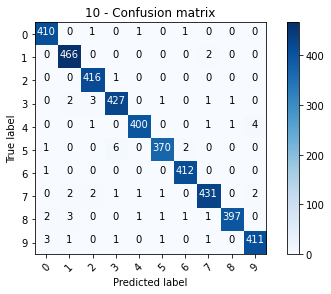

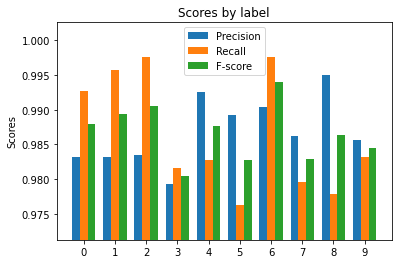

In [6]:
# ラベルの分布比率を維持した無作為抽出で10分割の交差検証を行う．シードは0で固定
skf = StratifiedKFold(n_splits=sp, shuffle = True, random_state = 0) 

for i, (train_idx, val_idx) in enumerate(skf.split(train, label_num)):
    # train(90%) / validation(10%) に分割
    X_train = train[train_idx]
    Y_train = label[train_idx]
    X_val = train[val_idx]
    Y_val = label[val_idx]
    
    # 分割ごとにモデルを初期化
    momentum = Adam(lr=learning_rate, decay=0.01)
    ResNetModel = ResnetBuilder.build_resnet_50(inputShape, n_classes) # ResNet-50
    ResNetModel.compile(optimizer=momentum, loss=losses.categorical_crossentropy, metrics=['acc'])

    # 学習を開始
    print("Iteration No. %d\n" %(i+1))
    
    # モデル読み込み時に使用するファイル
    model_file = 'img_classifier_model_%s_%s.h5' %(i+1, model_name)
    
    # 学習時に使用するコールバック
    def model_callbacks():
        # 各エポックでval_lossを監視し，最小値を更新した場合にモデルの重みを保存
        checkpoint = ModelCheckpoint(model_file, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        # early_stopping_patience回連続でval_loss下がらなければ，学習打ち止め
        early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=early_stopping_patience, verbose=1, mode='auto')

        return [checkpoint, early_stopping]

    callbacks_list = model_callbacks()
    
    # モデルのフィッティング
    history = ResNetModel.fit(X_train, 
                              Y_train, 
                              batch_size=batch_size, 
                              epochs=n_epoch,
                              verbose=1,
                              shuffle=True,
                              validation_data=(X_val, Y_val),
                              callbacks=callbacks_list)
    
    # 学習曲線の可視化
    def visualise_curve(model, monitor, itr):
        plt.figure()
        plt.plot(model.history[monitor])
        # validationも可視化する場合
        if isinstance(itr, int):
            plt.plot(model.history["val_"+ monitor])
        plt.title(str(itr)+":model "+ monitor)
        plt.ylabel(monitor)
        plt.xlabel("epoch")
        plt.legend(["train", "validation"], bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
        plt.savefig(csv_dir+"/"+str(itr)+" - "+monitor+".png", bbox_inches="tight")
        plt.show()
            
    visualise_curve(history, "acc", i+1) # accuracyに関して表示
    visualise_curve(history, "loss", i+1) # lossに関して表示
    
    # 最良のモデルでvalidationデータの性能評価
    loaded_model = ResnetBuilder.build_resnet_50(inputShape, n_classes)
    loaded_model.load_weights(model_file)
    loaded_model.compile(optimizer=momentum, loss=losses.categorical_crossentropy, metrics=['acc'])  
    plt.close("all")
    print("Done compiling best model.\n\n")
    
    # validationデータの予測
    predict[val_idx] = loaded_model.predict(X_val) # 各ラベルである確率
    predict_label[val_idx] = np_utils.to_categorical(np.argmax(predict[val_idx], axis=1), n_classes) # one-hot encoding
    
    # accuracyの表示
    print("%d. Accuracy on validation data: %f" %(i+1, accuracy_score(Y_val, predict_label[val_idx])))
    acc_str = str(i+1)+". Accuracy on validation data: "+ str(accuracy_score(Y_val, predict_label[val_idx]))+"\n\n"
    acc_list[i] = accuracy_score(Y_val, predict_label[val_idx])

    # その他の評価指標の表示と結果の保存
    print("Classification Report")
    report = classification_report(Y_val, predict_label[val_idx], target_names = class_names, digits = 5)+"\n\n"
    report_file=open(csv_dir + "/report_" + model_name + ".txt","a")
    report_file.write(acc_str + report)
    report_file.close()
    print(report)
    other_score = classification_report(Y_val, predict_label[val_idx], target_names = class_names, digits = 5, output_dict=True)
    
    for j in range(n_classes):
        precision_list[i,j] = other_score[str(j)]["precision"]
        recall_list[i,j] = other_score[str(j)]["recall"]
        fscore_list[i,j] = other_score[str(j)]["f1-score"]
        
    avg_precision[i] = other_score["macro avg"]["precision"]
    avg_recall[i] = other_score["macro avg"]["recall"]
    avg_fscore[i] = other_score["macro avg"]["f1-score"]

    # 混合行列の計算
    np.set_printoptions(precision=2)
    cnf_matrix = confusion_matrix(np.argmax(Y_val, axis=1), np.argmax(predict[val_idx], axis=1))

    # 混合行列の描画と保存
    def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
        plt.figure()
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        if normalize: # パーセント表記にしたい場合
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            filename = title + "_normalized.png"
        else: # 実際のデータ数で表示したい場合
            filename = title + "_nonnorm.png"

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.savefig(conf_dir + "/" + filename, bbox_inches="tight")
        plt.show()

    plot_confusion_matrix(cnf_matrix, classes = class_names, normalize=False, title=str(i+1)+" - Confusion matrix")
    
    # 各ラベルの精度に関してグラフ化
    def plot_scores(precision, recall, fscore, title):
        x = np.arange(len(class_names)) * 2 # ラベルの位置
        width = 0.5 # バーの横幅

        fig, ax = plt.subplots()
        rects1 = ax.bar(x - width, precision, width, label="Precision")
        rects2 = ax.bar(x, recall, width, label="Recall")
        rects3 = ax.bar(x + width, fscore, width, label="F-score")
        ylim_min = np.min([precision, recall, fscore]) - 0.005
        ylim_max = np.max([precision, recall, fscore]) + 0.005

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('Scores')
        ax.set_title('Scores by label')
        ax.set_xticks(x)
        ax.set_xticklabels(class_names)
        ax.set_ylim(ylim_min, ylim_max)
        ax.legend()

        plt.savefig(csv_dir + "/" + title)
        plt.show()
    
    plot_scores(precision_list[i], recall_list[i], fscore_list[i], title = str(i+1)+ " - Score.png")
    
    # 各交差検証の終わりに不要なデータを破棄
    clear_session()
    del ResNetModel, loaded_model, history, X_train, X_val, Y_train, Y_val
    gc.collect()
    
#clear_output()

# move h5 file
for i in glob.glob("*model*"+model_name+"*"+"h5"):
    shutil.move(i, model_dir)

# モデルファイルの削除
for i in glob.glob("*"+model_name+"*"):
    os.remove(i)

### 4.2.2 Total Results Report

Accuracy on all validarion data: 0.985500
Classification Report
              precision    recall  f1-score   support

           0    0.98372   0.99468   0.98917      4132
           1    0.99211   0.99360   0.99285      4684
           2    0.98586   0.98516   0.98551      4177
           3    0.99002   0.98000   0.98498      4351
           4    0.98938   0.98355   0.98645      4072
           5    0.98780   0.98129   0.98453      3795
           6    0.99081   0.99009   0.99045      4137
           7    0.98105   0.98818   0.98460      4401
           8    0.97513   0.98449   0.97979      4063
           9    0.97862   0.97278   0.97569      4188

   micro avg    0.98550   0.98550   0.98550     42000
   macro avg    0.98545   0.98538   0.98540     42000
weighted avg    0.98552   0.98550   0.98550     42000
 samples avg    0.98550   0.98550   0.98550     42000





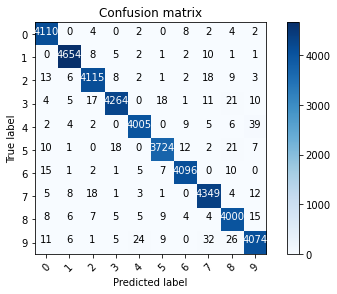

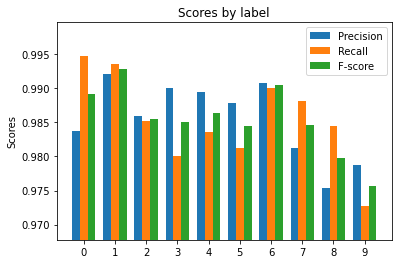

In [8]:
# 交差検証の結果の集計
plt.close('all')

# accuracyの表示
print('Accuracy on all validarion data: %f' %accuracy_score(label, predict_label))
acc_str = "Accuracy on all validarion data: "+ str(accuracy_score(label, predict_label))+"\n\n"

print('Classification Report')
report = classification_report(label, predict_label, target_names = class_names, digits = 5)+"\n\n"
report_file=open(csv_dir+"/report_"+ model_name + ".txt","a")
report_file.write(acc_str + report)
report_file.close()
print(report)

# 混合行列の計算
np.set_printoptions(precision=2)
cnf_matrix = confusion_matrix(np.argmax(label, axis=1), np.argmax(predict_label, axis=1))

# 混合行列の描画と保存
plot_confusion_matrix(cnf_matrix, classes = class_names, normalize=False, title='Confusion matrix')

# 各交差検証の評価値を集計
score_table = pd.DataFrame(index = list(range(1,sp+1)))
score_table["Accuracy"] = acc_list
score_table["avg_Precision"] = avg_precision
score_table["avg_Recall"] = avg_recall
score_table["avg_F-score"] = avg_fscore

for i in range(n_classes):
    score_table[str(i) + "_Precision"] = precision_list[:, i]
    score_table[str(i) + "_Recall"] = recall_list[:, i]    
    score_table[str(i) + "_F-score"] = fscore_list[:, i]    
    
# 平均と標準偏差を計算して追加
avg = pd.Series(score_table.mean(),name="Avg")
std = pd.Series(score_table.std(),name="Std")

# 資料等に乗せるために整形したものも追加　(平均精度を % 表記，括弧内に標準偏差)
sr = []
for col in score_table.columns:
    sr.append(str(round(avg[col]*100,1))+"("+str(round(std[col]*100,1))+")%")
    
sr = pd.Series(sr, index=score_table.columns, name="sr")

# 追加データを結合
score_table = score_table.append(avg)
score_table = score_table.append(std)
score_table = score_table.append(sr)

# 結果ファイルを出力
score_table.to_csv(csv_dir+"/Result_"+model_name+".csv")

# 各ラベルの精度に関してグラフ化
plot_scores(avg[4:35:3], avg[5:35:3], avg[6:35:3], title = "Score.png")

### 4.2.3 Error data results

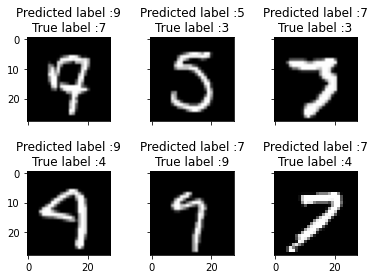

In [9]:
# 間違って推測したラベルの予測値と正しいラベルの予測値の差が大きいデータを上位6枚表示
predict_label_num = np.argmax(predict, axis=1) # 予測されたクラス名
errors = (predict_label_num - label_num != 0) # 間違ったデータはTrue

pred_classes_errors = predict_label_num[errors] # エラーデータの予測されたクラス名を抽出
pred_errors = predict[errors] # エラーデータの各クラスの予測値
true_errors = label_num[errors] # エラーデータの正しいクラス名
val_errors = train[errors] # エラーデータ（画像）

# 予測ラベルと正解ラベルを表記して，エラーデータを表示する関数
def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    # 余白を設定
    plt.subplots_adjust(wspace=0.4, hspace=0.6)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)), cmap='gray')
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
    plt.savefig(csv_dir + "/" + "Error.png")

# エラーデータが間違って予測されたクラスの予測値を抽出
pred_errors_prob = np.max(pred_errors,axis = 1)

# エラーデータの正しいクラスの予測値を抽出
true_prob_errors = np.diagonal(np.take(pred_errors, true_errors, axis=1))

# 予測されたクラスと正しいクラスの予測値の差
delta_pred_true_errors = pred_errors_prob - true_prob_errors

# delta_pred_true_errorsを小さい順にソートした時のインデックスを抽出
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# 正解ラベルとの予測値の差が大きいデータのインデックスを上位6個抽出
most_important_errors = sorted_dela_errors[-6:]

# 表示
display_errors(most_important_errors, val_errors, pred_classes_errors, true_errors)

# 5. All data training and test

## 5.1 Training

Train on 42000 samples
Epoch 1/10
42000/42000 [==============================] - 22s 520us/sample - loss: 4.8153 - acc: 0.9471
Epoch 2/10
42000/42000 [==============================] - 14s 328us/sample - loss: 3.7664 - acc: 0.9866
Epoch 3/10
42000/42000 [==============================] - 14s 340us/sample - loss: 3.1789 - acc: 0.9963
Epoch 4/10
42000/42000 [==============================] - 14s 329us/sample - loss: 2.7838 - acc: 0.9993
Epoch 5/10
42000/42000 [==============================] - 14s 332us/sample - loss: 2.4960 - acc: 0.9999
Epoch 6/10
42000/42000 [==============================] - 14s 341us/sample - loss: 2.3127 - acc: 0.9951 - los
Epoch 7/10
42000/42000 [==============================] - 14s 341us/sample - loss: 2.1368 - acc: 0.9996
Epoch 8/10
42000/42000 [==============================] - 14s 343us/sample - loss: 2.0093 - acc: 0.9990 - loss: 2.0136 - acc:
Epoch 9/10
42000/42000 [==============================] - 14s 345us/sample - loss: 1.8980 - acc: 0.9998
Epoch 10/10
4

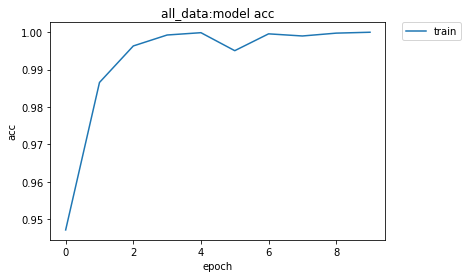

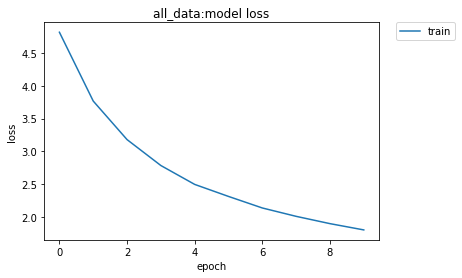

In [18]:
# モデルの初期化
momentum = Adam(lr=learning_rate, decay=0.01)
ResNetModel = ResnetBuilder.build_resnet_50(inputShape, n_classes)
ResNetModel.compile(optimizer=momentum, loss=losses.categorical_crossentropy, metrics=['acc'])

# モデルのフィッティング
history = ResNetModel.fit(train, label, batch_size=batch_size, epochs=n_epoch, verbose=1, shuffle=True)

# 学習曲線の可視化
visualise_curve(history, "acc", "all_data") # accuracyに関して表示
visualise_curve(history, "loss", "all_data") # lossに関して表示

## 5.2 Test

In [20]:
# testデータの予測
test_predict = ResNetModel.predict(test) # 各ラベルである確率
test_predict_label = np.argmax(test_predict, axis=1) # 予測ラベル（0-9）

# 予測結果をcsvに出力
result = pd.DataFrame({"ImageId" : list(range(1,len(test)+1)),
                       "Label" : test_predict_label})
result.to_csv(csv_dir + "/Test_Result1.csv", index = False)

# モデルの破棄
clear_session()
del ResNetModel, history
gc.collect()

523553

# 6. Ensemble model test

In [15]:
# 各バリデーションモデルの予測値の平均
test_predict = np.zeros((len(test), n_classes))
for model_file in glob.glob(model_dir+"/*"):
    loaded_model = ResnetBuilder.build_resnet_50(inputShape, n_classes)
    loaded_model.load_weights(model_file)
    loaded_model.compile(optimizer=momentum, loss=losses.categorical_crossentropy, metrics=['acc'])  
    test_predict += loaded_model.predict(test)
    # モデルの破棄
    clear_session()
    del loaded_model
    gc.collect()

test_predict /= n_classes # 各ラベルである確率
test_predict_label = np.argmax(test_predict, axis=1) # 予測ラベル（0-9）

# 予測結果をcsvに出力
result = pd.DataFrame({"ImageId" : list(range(1,len(test)+1)),
                       "Label" : test_predict_label})
result.to_csv(csv_dir + "/Test_Result2.csv", index = False)